# Relative Entropy Demo

---

Authors: Aaron Spring

This is a work in progress for the relative entropy method.

In [1]:
import xarray as xr
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
from PMMPIESM.setup import _get_path

In [3]:
ds = xr.open_dataset(_get_path('tos',prefix='ds')).rename({'ensemble':'initialization'})
control = xr.open_dataset(_get_path('tos',prefix='control')).rename({'time':'initialization'})

In [4]:
ds

<xarray.Dataset>
Dimensions:         (initialization: 12, member: 10, time: 21, x: 256, y: 220)
Coordinates:
    lon             (y, x) float64 ...
    lat             (y, x) float64 ...
  * member          (member) int64 0 1 2 3 4 5 6 7 8 9
  * initialization  (initialization) int64 3014 3023 3045 ... 3228 3237 3257
  * time            (time) int64 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21
Dimensions without coordinates: x, y
Data variables:
    tos             (time, initialization, member, y, x) float32 ...

In [5]:
control

<xarray.Dataset>
Dimensions:         (initialization: 301, x: 256, y: 220)
Coordinates:
    lon             (y, x) float64 ...
    lat             (y, x) float64 ...
  * initialization  (initialization) int64 3000 3001 3002 ... 3298 3299 3300
Dimensions without coordinates: x, y
Data variables:
    tos             (initialization, y, x) float32 ...

In [6]:
from climpred.relative_entropy import compute_relative_entropy, bootstrap_relative_entropy
from climpred.graphics import plot_relative_entropy

# perfect-model

In [12]:
rel_ent = compute_relative_entropy(ds, control,nmember_control=100,neofs=8)

In [13]:
rel_ent.to_dataframe().unstack(0).head()

R                                                       \
initialization      3014      3023       3045      3061       3124       3139   
time                                                                            
1               9.660666  7.275701  13.187704  9.668649  11.840107  13.165167   
2               6.459936  4.898388   7.886870  5.392100   8.537514   7.863739   
3               5.517626  5.997578   7.866694  4.874664   7.938522   5.554792   
4               7.187055  4.785376   6.970994  5.234552   7.406502   7.716097   
5               6.732817  5.164069   6.551013  3.448952   7.970315   4.013123   

                                                             ...            D  \
initialization       3144       3175      3178       3228    ...         3045   
time                                                         ...                
1               13.185962  10.013759  9.686421  13.355951    ...     7.893495   
2                9.128014   6.168240  5.532171   6.992205    ...     4.942850   
3                6.739549   6.453844  8.633258   7.872407    ...     6.207746   
4                7.367067   6.756313  4.970418   6.688802    ...     5.438232   
5                6.104869   3.846882  4.877370   5.597362    ...     5.428341   

                                                                            \
initialization      3061      3124      3139      3144      3175      3178   
time                                                                         
1               7.719523  8.656957  7.805331  7.008873  8.545568  8.400330   
2               4.476395  4.653023  4.726750  5.091978  5.139656  4.423426   
3               3.815511  4.884037  3.635793  4.224789  5.101135  7.748439   
4               4.585624  4.180612  6.529564  4.953081  5.976100  4.497430   
5               3.214859  4.760295  2.815793  4.678722  3.088244  4.281953   

                                              
initialization      3228      3237      3257  
time                                          
1               8.667890  7.576104  6.351748  
2               3.428376  4.198594  5.573745  
3               4.918273  4.939582  3.505230  
4               3.655100  3.455731  5.168977  
5               2.624173  3.704867  4.698352  

[5 rows x 36 columns]

In [14]:
rel_ent_threshold = bootstrap_relative_entropy(ds, control, sig=50,
                               bootstrap=50, curv=True, neofs=8,
                               nmember_control=100)

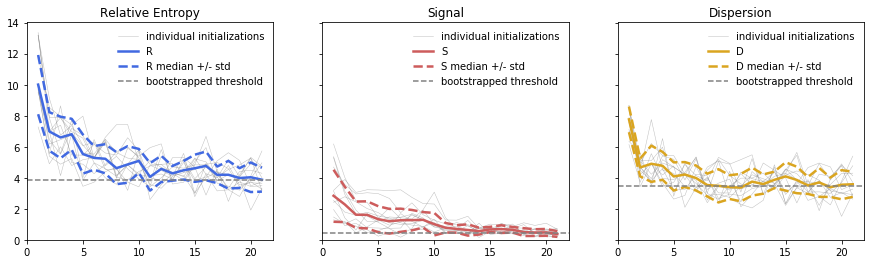

In [15]:
plot_relative_entropy(rel_ent, rel_ent_threshold=rel_ent_threshold, sharey=True, figsize=(15,4))

# DPLE, LENS
faking data with DPLE, LENS coords

In [16]:
def _shuffle(ds, dim='initialization'):
    """Shuffle ensemble members to uninitialize the data."""
    old_dim_range = ds[dim]
    shuffled = ds.sel({dim: np.random.permutation(ds[dim])})
    shuffled[dim] = old_dim_range
    shuffled = shuffled.sortby(dim)
    return shuffled

In [17]:
lens = xr.concat([_shuffle(control,'initialization') for _ in range(10)],dim='member').isel(initialization=slice(0,65)).assign(initialization=np.arange(1950,2015))
lens = lens.assign(member=np.arange(lens.member.size))
lens

<xarray.Dataset>
Dimensions:         (initialization: 65, member: 10, x: 256, y: 220)
Coordinates:
    lon             (y, x) float64 -47.25 -47.69 -48.12 ... 131.3 132.5 133.8
    lat             (y, x) float64 76.36 76.3 76.24 ... -77.25 -77.39 -77.54
  * initialization  (initialization) int64 1950 1951 1952 ... 2012 2013 2014
  * member          (member) int64 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: x, y
Data variables:
    tos             (member, initialization, y, x) float32 nan nan ... nan nan

In [18]:
dple = xr.concat([ds]*6,'initialization').isel(initialization=slice(0,65)).isel(time=slice(0,5))
dple = dple.assign(initialization=lens.initialization.values)
dple

<xarray.Dataset>
Dimensions:         (initialization: 65, member: 10, time: 5, x: 256, y: 220)
Coordinates:
    lon             (y, x) float64 -47.25 -47.69 -48.12 ... 131.3 132.5 133.8
    lat             (y, x) float64 76.36 76.3 76.24 ... -77.25 -77.39 -77.54
  * member          (member) int64 0 1 2 3 4 5 6 7 8 9
  * time            (time) int64 1 2 3 4 5
  * initialization  (initialization) int64 1950 1951 1952 ... 2012 2013 2014
Dimensions without coordinates: x, y
Data variables:
    tos             (time, initialization, member, y, x) float32 nan nan ... nan

In [19]:
compute_relative_entropy(dple, lens,ntime=4,nmember_control=5,neofs=3).to_dataframe().unstack(0).head()

R                                                    \
initialization      1950      1951      1952      1953      1954      1955   
time                                                                         
1               2.361987  2.419853  4.979725  3.159554  3.140110  4.737523   
2               0.974119  1.672449  2.765949  0.663521  0.819140  3.446355   
3               0.839712  1.621563  0.712448  2.532792  2.058706  0.451901   
4               0.696062  0.024998  2.112752  1.454178  2.275990  1.382867   

                                                          ...            D  \
initialization      1956      1957      1958      1959    ...         2005   
time                                                      ...                
1               6.060548  2.236325  1.445347  2.766607    ...     1.368195   
2               2.978227  0.847832  1.738861  2.386457    ...     0.309981   
3               0.834049  0.866950  0.990686  7.637332    ...     0.185309   
4               0.910005 -0.221499  0.288763  2.076821    ...     0.016893   

                                                                            \
initialization      2006      2007      2008      2009      2010      2011   
time                                                                         
1               0.483342  0.331435  1.768142  1.544416  1.194628  1.244473   
2               0.430484 -0.267722  0.293846  0.815070  0.073127  0.435569   
3               0.171818  0.526320  0.130791  0.548129  0.218382  1.141523   
4              -0.014845  0.207524  0.248449  0.316892  0.244928  0.059341   

                                              
initialization      2012      2013      2014  
time                                          
1               1.345279  0.741746  0.653127  
2               0.648796  0.290133  0.149117  
3               0.034824  0.688107  0.612941  
4               0.467831  0.670987  0.424206  

[4 rows x 195 columns]

# Understand nmember_control


 nmember_control = 5


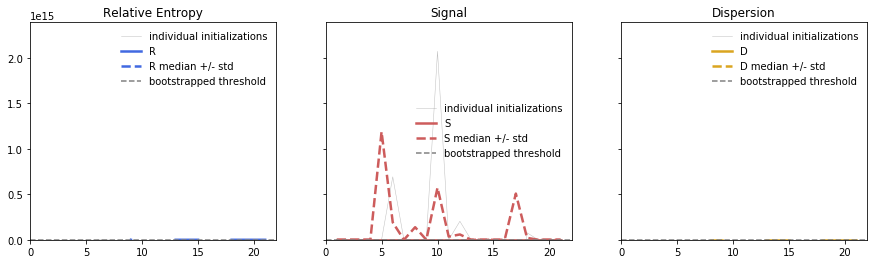


 nmember_control = 10


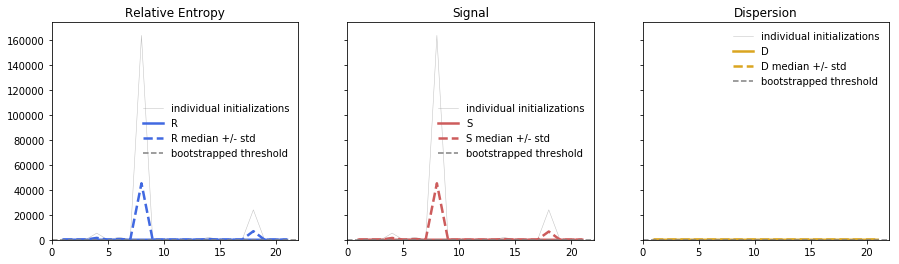


 nmember_control = 20


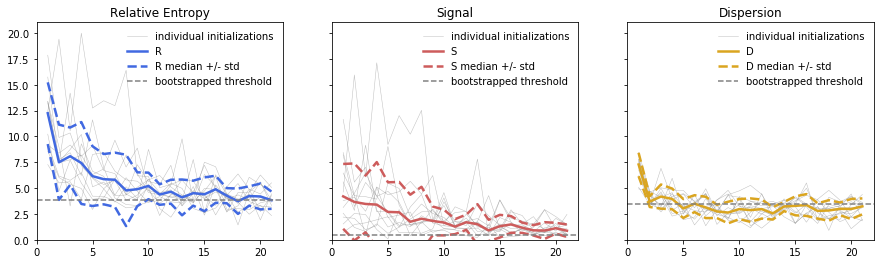


 nmember_control = 50


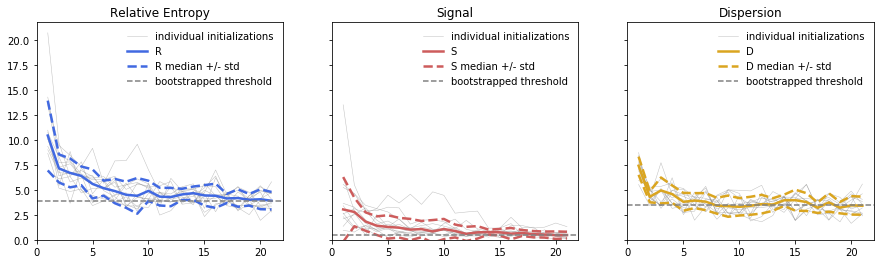


 nmember_control = 100


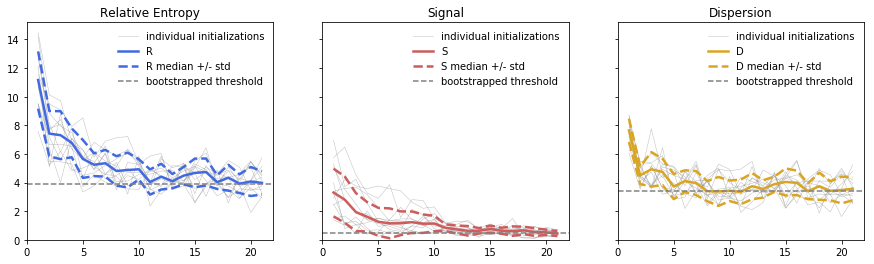

In [21]:
import matplotlib.pyplot as plt
neofs=8
for i in [5,10,20,50,100]:
    print('\n nmember_control =',i)
    rel_ent = compute_relative_entropy(ds, control,nmember_control=i,neofs=neofs)
    el_ent_threshold = bootstrap_relative_entropy(ds, control, sig=50,
                               bootstrap=50, curv=True, neofs=neofs,
                               nmember_control=i)
    plot_relative_entropy(rel_ent, rel_ent_threshold=rel_ent_threshold, sharey=True, figsize=(15,4))
    plt.show()